In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
import gc
from time import time
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from hyperopt import fmin, tpe, hp,Trials,STATUS_OK,space_eval

import japanize_matplotlib
import optuna

In [2]:
train=pd.read_feather('../data/train_feat2.ftr')
test=pd.read_feather('../data/test_feat2.ftr')
Y_train=train.rent
X_train=train.drop(['id','rent'],axis=1)

test.index=test['index']
X_test=test.drop(['id','rent','index'],axis=1)

In [3]:
categorical_features=list(X_train.columns[X_train.dtypes=='category'])

In [4]:
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [15]:
params = {
    'max_bin' : 63,
    'n_estimators' : 10000,
    'learning_rate': 0.01,
    'min_data_in_leaf' : 50,
    'num_leaves' : 100,
    'sparse_threshold' : 1.0,
    'device' : 'cpu',
    'save_binary': True,
    'seed' : 42,
    'feature_fraction_seed': 42,
    'bagging_seed' : 42,
    'drop_seed' : 42,
    'data_random_seed' : 42,
    'objective' : 'regression',
    'boosting_type' : 'gbdt',
    'verbose' : 0,
    'metric' : 'RMSE',
    'is_unbalance' : True,
    'boost_from_average' : False,
}

In [29]:
splits = 5
folds = KFold(n_splits=splits,shuffle=True)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

y_preds = np.zeros(X_test.shape[0])

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="rmse",
            early_stopping_rounds=100,
            categorical_feature = categorical_features,
            verbose= 500)
    
    del X_trn, y_trn
    
    val=reg.predict(X_val)
    feature_importances['fold_{}'.format(fold_n + 1)] = reg.feature_importances_
    
    y_preds+=reg.predict(X_test)/splits
    del reg, X_val
    print('RMSE accuracy: {}'.format(rmse(y_val, val)))
    del val,y_val

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 18354.6	valid_1's rmse: 24220.7
Early stopping, best iteration is:
[879]	training's rmse: 14690.2	valid_1's rmse: 23846.6
RMSE accuracy: 23846.631774761692
fold completed in 25.35057306289673s
** Training fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 18967.7	valid_1's rmse: 20239
Early stopping, best iteration is:
[768]	training's rmse: 16216.8	valid_1's rmse: 19850.5
RMSE accuracy: 19850.51733038263
fold completed in 25.591723203659058s
** Training fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 17422.8	valid_1's rmse: 27538.7
[1000]	training's rmse: 13325.5	valid_1's rmse: 25646.6
[1500]	training's rmse: 11088.2	valid_1's rmse: 24742.8
[2000]	training's rmse: 9613.42	valid_1's rmse: 24242.8
[2500]	training's rmse: 8530.99	valid_1's rmse: 23920.8
[3000]	training's rmse: 7695.04	valid_1's rms

In [ ]:
y_preds

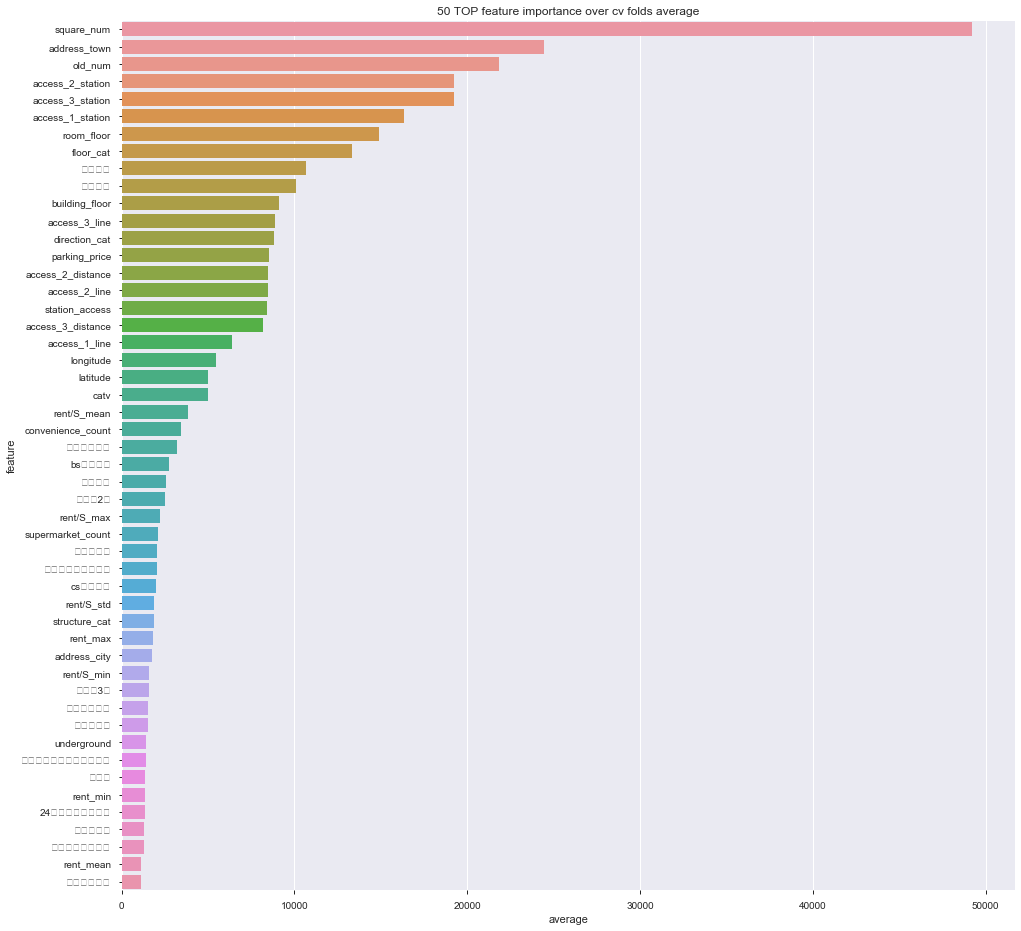

In [32]:
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances.to_feather('feat2_lighgbm_importance.ftr')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');
plt.savefig('feat2_lighgbm_importance.png')

In [13]:
def opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    
    FOLD=5
    folds=KFold(n_splits=FOLD,shuffle=True)
    val_score=[]
    for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
        cv_fold_start_time = time()
        print ('** Training fold {}'.format(fold_n + 1))
        X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
        y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
        eval_set  = [(X_trn,y_trn), (X_val, y_val)]

        reg =lgb.LGBMRegressor(
        random_state=42,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        objective='regression',
        merics='rmse')
        
        reg.fit(X_trn, y_trn,
                eval_set=eval_set, 
                eval_metric="rmse",
                early_stopping_rounds=100,
                categorical_feature = categorical_features,
                verbose= 500)

        del X_trn, y_trn

        val_pred=reg.predict(X_val)
        val_score+=rmse(y_val,val_pred)
        
        cv_fold_end_time = time()
        print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))
    print(val_score)
    
    return np.mean(val_score)

study = optuna.create_study()
study.optimize(opt, n_trials=100)

** Training fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l2: 4.48935e+07	training's rmse: 6700.26	valid_1's l2: 1.9607e+08	valid_1's rmse: 14002.5
Did not meet early stopping. Best iteration is:
[919]	training's l2: 1.78435e+07	training's rmse: 4224.15	valid_1's l2: 1.91486e+08	valid_1's rmse: 13837.8
fold completed in 3.5152618885040283s
** Training fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[178]	training's l2: 1.1977e+08	training's rmse: 10944	valid_1's l2: 3.81696e+08	valid_1's rmse: 19537
fold completed in 1.2105460166931152s
** Training fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's l2: 4.64967e+07	training's rmse: 6818.85	valid_1's l2: 5.45445e+08	valid_1's rmse: 23354.8
Did not meet early stopping. Best iteration is:
[919]	training's l2: 1.96378e+07	training's rmse: 4431.46	valid_1's l2: 5.32952e+08	valid_1's rmse: 23085.7
fold complete

[W 2019-10-10 19:38:49,439] Setting status of trial#0 as TrialState.FAIL because the objective function returned nan.


** Training fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l2: 2.39984e+07	training's rmse: 4898.82	valid_1's l2: 4.97199e+08	valid_1's rmse: 22298
Did not meet early stopping. Best iteration is:
[561]	training's l2: 2.06256e+07	training's rmse: 4541.55	valid_1's l2: 4.95585e+08	valid_1's rmse: 22261.7
fold completed in 2.601505994796753s
** Training fold 2
Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: 

In [7]:
def objective(trial):
    drop_rate = trial.suggest_uniform('drop_rate', 0, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.8, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 5, 1000)
    verbosity = trial.suggest_int('verbosity', -1, 1)
    num_boost_round = trial.suggest_int('num_boost_round', 10, 100000)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100000)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 500)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 500)

    params = {"objective": "regression",
              "boosting_type": "gbdt",
              "learning_rate": learning_rate,
              "num_leaves": num_leaves,
              "max_bin": 256,
              "feature_fraction": feature_fraction,
              "verbosity": verbosity,
              "drop_rate": drop_rate,
              "is_unbalance": False,
              "max_drop": 50,
              "min_child_samples": min_child_samples,
              "min_child_weight": min_child_weight,
              "min_split_gain": 0,
              "min_data_in_leaf": min_data_in_leaf,
              "subsample": subsample,
                'metric' : 'RMSE'
              }

    x_score = []
    final_cv_train = np.zeros(len(Y_train))
    final_cv_pred = np.zeros(len(X_test))

    cv_train = np.zeros(len(Y_train))
    cv_pred = np.zeros(len(X_test))

    params['seed'] = 0
    NFOLDS = 4
    
    kfold=KFold(n_splits=NFOLDS)
    kf = kfold.split(X_train,Y_train)

    best_trees = []
    fold_scores = []

    for fold_, (train_index, valid_index) in enumerate(kf):
        print('kfold_index:', fold_)
 
        X_trn, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_trn, y_val = Y_train[train_index], Y_train[valid_index]
        eval_set  = [(X_trn,y_trn), (X_val, y_val)]

        reg = lgb.LGBMRegressor(**params)
        reg.fit(X_trn, y_trn,
                eval_set=eval_set, 
                eval_metric="rmse",
                early_stopping_rounds=100,
                categorical_feature = categorical_features,
                verbose= 500)
        
        best_trees.append(reg.best_iteration_)
        
        cv_pred += reg.predict(X_test, num_iteration=reg.best_iteration_)
        
        cv_train[valid_index] += reg.predict(X_val)

        score = rmse(y_val, cv_train[valid_index])
        print('RMSE:',score)
        
        fold_scores.append(score)

    cv_pred /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_pred

    print("cv score:")
    print(rmse(Y_train, cv_train))
    print("current score:", rmse(Y_train , final_cv_train / (fold_ + 1.)), fold_+1)
    print(fold_scores)
    print(best_trees, np.mean(best_trees))

    x_score.append(rmse(Y_train, cv_train))
    print(x_score)

    return x_score[0]

study = optuna.create_study()
study.optimize(objective, n_trials=150)

kfold_index: 0
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139026	valid_1's rmse: 140730
RMSE: 75987.02717765037
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139875	valid_1's rmse: 138513
RMSE: 71398.0109276154
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139203	valid_1's rmse: 140202
RMSE: 75004.66656547153
kfold_index: 3
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139491	valid_1's rmse: 138136


[I 2019-10-10 19:29:09,431] Finished trial#0 resulted in value: 73751.2030177544. Current best value is 73751.2030177544 with parameters: {'drop_rate': 0.6460775527434223, 'feature_fraction': 0.6263738290744885, 'learning_rate': 0.9822626187492082, 'subsample': 0.9074702629888286, 'num_leaves': 833, 'verbosity': -1, 'num_boost_round': 27232, 'min_data_in_leaf': 49914, 'min_child_samples': 376, 'min_child_weight': 19}.


RMSE: 72522.63558898438
cv score:
73751.2030177544
current score: 115369.94849709515 4
[75987.02717765037, 71398.0109276154, 75004.66656547153, 72522.63558898438]
[1, 1, 1, 1] 1.0
[73751.2030177544]
kfold_index: 0
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139026	valid_1's rmse: 140730
RMSE: 75987.02717765037
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139875	valid_1's rmse: 138513
RMSE: 71398.0109276154
kfold_index: 2
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139203	valid_1's rmse: 140202
RMSE: 75004.66656547153
kfold_index: 3
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139491	valid_1's rmse: 138136


[I 2019-10-10 19:29:11,398] Finished trial#1 resulted in value: 73751.2030177544. Current best value is 73751.2030177544 with parameters: {'drop_rate': 0.6460775527434223, 'feature_fraction': 0.6263738290744885, 'learning_rate': 0.9822626187492082, 'subsample': 0.9074702629888286, 'num_leaves': 833, 'verbosity': -1, 'num_boost_round': 27232, 'min_data_in_leaf': 49914, 'min_child_samples': 376, 'min_child_weight': 19}.


RMSE: 72522.63558898438
cv score:
73751.2030177544
current score: 115369.94849709515 4
[75987.02717765037, 71398.0109276154, 75004.66656547153, 72522.63558898438]
[1, 1, 1, 1] 1.0
[73751.2030177544]
kfold_index: 0
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139026	valid_1's rmse: 140730
RMSE: 75987.02717765037
kfold_index: 1
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 139875	valid_1's rmse: 138513


KeyboardInterrupt: 